In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DS/Time_series_project_3

/content/drive/MyDrive/DS/Time_series_project_3


In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import norm

import sys
from pathlib import Path
import statistics
from statistics import median


In [ ]:
from ts_forecast.changepoint_detection import *

Также в ходе работы над проектом перед нами была поставлена задача обнаружения разладки. В данном случае задачей обнаружения разладки является установление факта разладки, и, если считается, что разладка произошла - оценивание момента разладки. Важно отметить тот факт, что появление разладки влияет на процесс предсказания. В случае обнаружения краткосрочной разладки, алгоритм продолжает обучение, так как этот процесс несильно повлияет на средние предсказания. Если же наблюдается более долгий процесс разладки, обучение прекращается и позиционер получает уведомление о том, что пора переходить на «ручной режим».

In [ ]:
data = pd.read_csv('data/ts_project_data_full.csv', index_col='Date')
data.index = pd.to_datetime(data.index, format='%Y-%m-%d') # utc=True
data.head()

,Income,Outcome,Balance,Nalog,Moex,Brent,Libor,Rvi,Covid_cases,Covid_deaths,Key_rate,Inflation,Dollar,Euro,Gold
Date,,,,,,,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,1,2211.25,54.94,0.69300,25.59,0,0,10.0,5.0,59.8495,63.0176,2264.82
2017-01-10,1.068610,1.194182,-0.125572,0,2237.49,53.64,0.69333,23.83,0,0,10.0,5.0,59.9672,63.5227,2280.67
2017-01-11,0.944429,0.936663,0.007767,0,2218.61,55.10,0.69278,25.20,0,0,10.0,5.0,60.1430,63.3733,2297.00
2017-01-12,1.672202,0.875379,0.800391,0,2212.00,56.01,0.69278,23.64,0,0,10.0,5.0,59.3784,63.1847,2308.20
2017-01-13,0.955924,0.975645,-0.019721,1,2195.19,55.45,0.69278,24.79,0,0,10.0,5.0,59.3602,63.1565,2283.58


Критерий Неймана-Пирсона предписывает
принимать гипотезу исходя из значения величины
$$
L_n(X_1, \ldots, X_n) = \frac{f_0(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)},
$$
называемой отношением правдоподобия.
А именно, пусть $\varphi(X_1, \ldots, X_n)$~-- 
рандомизированное решающее правило, значение
которого равно вероятности принять 
гипотезу $\mathbb{H}_1$. Тогда найдутся такие
константы $\lambda_a$ и $h_a$, что 
$$
\varphi(X_1, \ldots, X_n) = 
\begin{cases}
    1, & L_n(X_1, \ldots, X_n) > h_a, \\
    \lambda_a, & L_n(X_1, \ldots, X_n) = h_a, \\
    0, & L_n(X_1, \ldots, X_n) < h_a,
\end{cases}
$$
является наиболее мощным 
(т.е. с наименьшей вероятностью пропуска цели 
или ошибки 2 рода $\beta(\varphi)$) тестом 
среди тестов, вероятность ложной
тревоги $\alpha(\varphi)$
(ошибки 1 рода) которых не выше $a$.

In [ ]:
mean_diff = -0.01

stat_trajectory = []
mean_values = []

cusum = AdjustedCusum(mean_diff, threshold=0.03)
for k, x_k in enumerate(data['Balance'].values):
    cusum.update_value(x_k)
    cusum.count()
    stat_trajectory.append(cusum.metric)
    mean_values.append(cusum.mean_hat)

- В каждый новый момент времени $t$ по вновь поступившему наблюдению $X_t$ производится вычисление стандартизованного и центрированного значения $Z_t = (X_t - \hat{\mu_{t-1}}) / \hat{\sigma_{t-1}}$, где $\hat{\mu_{t-1}}$ и $\hat{\sigma}^2_{t-1}$ - оценки среднего и дисперсии с помощью экспоненциального сглаживания, полученная по наблюдениям до момента времени $t-1$ включительно
- Переоценить среднее значение новыми данными согласно $\hat{\mu}_{t} = (1 - \alpha) \hat{\mu}_{t - 1} + \alpha X_t$
- Переоценить дисперсию новыми данными согласно $\hat{\sigma}^2_{t} = (1 - \beta) \hat{\sigma}^2_{t - 1} + \beta (X_t - \hat{\mu}_{t})^2$

In [ ]:
sigma_diff = 2.0

stat_trajectory, mean_values, var_values, diff_values = [], [], [], []
timestamps, values, changepoint = [], [], []

mean_exp = MeanExp(new_value_weight=0.05)
var_exp = MeanExp(new_value_weight=0.005)
sr = ShiryaevRoberts(sigma_diff=sigma_diff, threshold=20)
for k, x_k in enumerate(data['Balance'].values):
    values.append(x_k)
    try:
        mean_estimate = mean_exp.value
    except MeanExpNoDataException:
        mean_estimate = 0.
    
    try:
        var_estimate = var_exp.value
    except MeanExpNoDataException:
        var_estimate = 1.
    
    predicted_diff_value = (x_k - mean_estimate) ** 2
    predicted_diff_mean = var_estimate
    sr.update(predicted_diff_value - predicted_diff_mean)
    diff_values.append(predicted_diff_value - predicted_diff_mean)
    
    mean_exp.update(x_k)
    diff_value = (x_k - mean_estimate) ** 2
    var_exp.update(diff_value)
    
    stat_trajectory.append(sr.metric)
    mean_values.append(mean_estimate)
    var_values.append(np.sqrt(var_estimate))

<ipython-input-11-31f44a057364>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(np.array(mean_values) + np.sqrt(var_values), 'k', color='grey', label='threshold')
<ipython-input-11-31f44a057364>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(np.array(mean_values) - np.sqrt(var_values), 'k', color='grey')


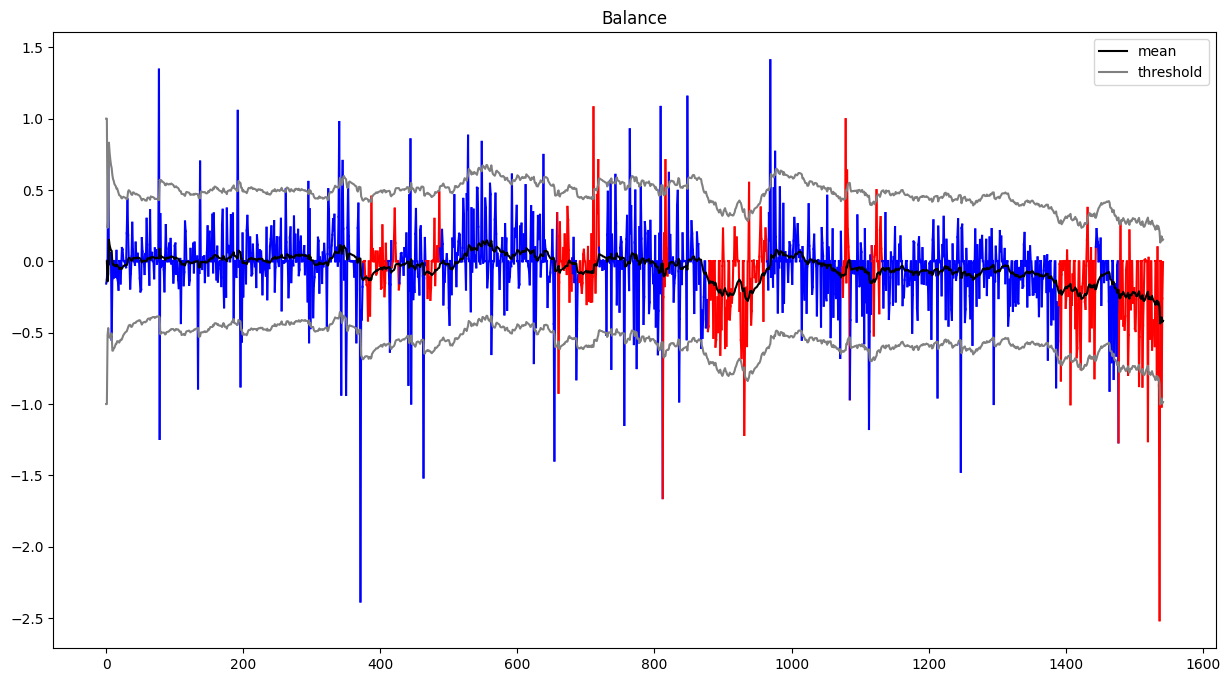

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1, len(data['Balance'].values)):
    
    x = [i-1, i]
    y = [data['Balance'].values[i-1], data['Balance'].values[i]]
    
    ax.plot(x, y, color=cusum.breakpoints[i])
    
ax.plot([i for i in range(1, len(stat_trajectory))], mean_values[1:], color='black', label='mean')  
ax.plot(np.array(mean_values) + np.sqrt(var_values), 'k', color='grey', label='threshold')
ax.plot(np.array(mean_values) - np.sqrt(var_values), 'k', color='grey')
plt.title('Balance')
plt.legend()
plt.show()

In [ ]:
alpha = 0.05
beta = 0.005
mean_diff = -0.01
stat_trajectory = []

cumsum = AdjustedCusum(mean_diff, 30.)
for k, x_k in enumerate(data['Balance'].values):
    cumsum.update(x_k)
    stat_trajectory.append(cumsum._stat)

Кумулятивные суммы принимают в качестве параметра относительное отклонение в среднем значении такое, что $\mu_0 = \mu_{\infty} + \Delta$.

Основная идея метода состоит в вычислении особых характеристик, так 
называемых кумулятивных сумм. Когда значение суммы на определенной 
итерации превышает ранее заданное пороговое значение, фиксируется 
разладка.

На графике кумулятивных сумм ниже хорошо видно, когда фиксируется разладка. 

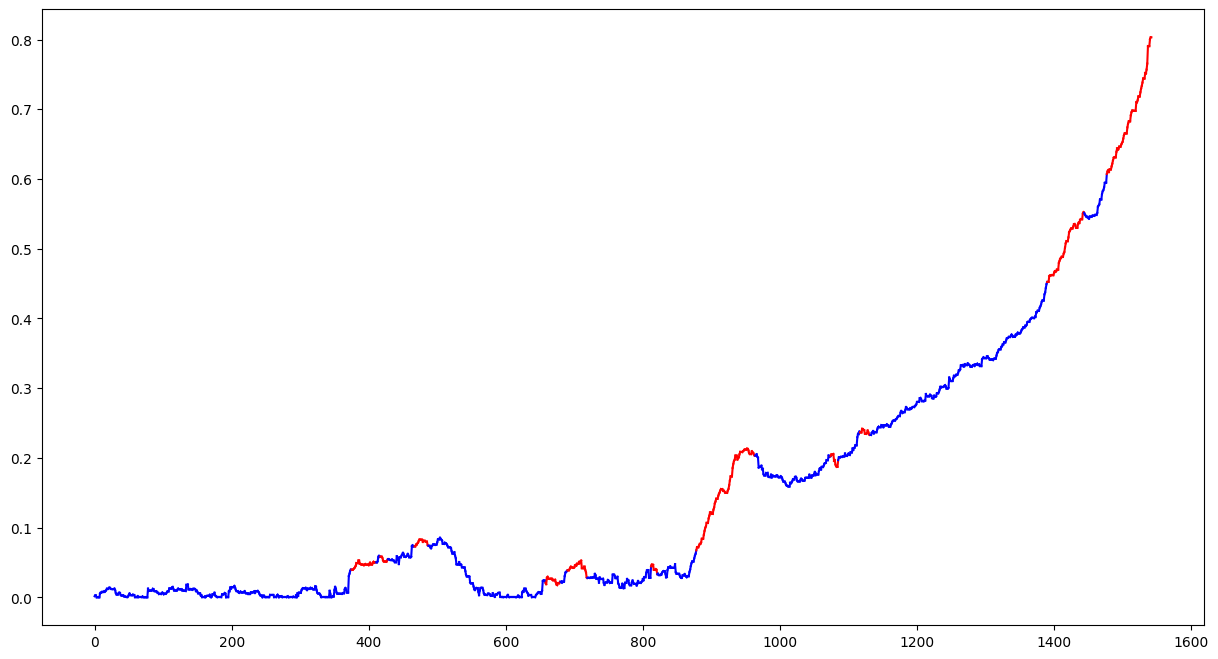

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(1, len(data['Balance'].values)):
    
    x = [i-1, i]
    y = [np.array(stat_trajectory)[i-1], np.array(stat_trajectory)[i]]
    ax.plot(x, y, color=cusum.breakpoints[i])

**Статистика Ширяева-Робертса.**

 - Вводится статистика
$$
R_n = \sum\limits_{\theta = 1}^{n} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
$$

 - Если случайные величины $X_1, \ldots, X_n$ независимы, то
$$
R_n = \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} =
        \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    l_k.
$$ 

 - Статистика $R_n$ обладает свойством $R_n = (1 + R_{n-1}) l_k$ и~называется статистикой Ширяева-Робертса (Shiryaev-Roberts, SR).
 
 - Момент остановки 
$$
\tau_{\mathrm{SR}} = \inf \{n \geqslant 0: R_n \geqslant B\},
$$
построенный по статистике Ширяева-Робертса,
оптимален в классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до ложной тревоги не меньше $T$.


- Разладка в дисперсии означает высокое значение разности оценки $\hat{\sigma}^2_{t}$ и значения $(X_t - \hat{\mu}_{t})^2$, поэтому именно эту разность $\hat{\sigma}^2_{t} - (X_t - \hat{\mu}_{t})^2$ мы будем подавать на вход процедуре Ширяева-Робертса (настроенной на поиск разладки "на увеличение")

Остальные шаги алгоритма полностью соответствуют случаю неизвестных моментов временного ряда:
- Переоценить среднее значение новыми данными согласно $\hat{\mu}_{t} = (1 - \alpha) \hat{\mu}_{t - 1} + \alpha X_t$
- Переоценить дисперсию новыми данными согласно $\hat{\sigma}^2_{t} = (1 - \beta) \hat{\sigma}^2_{t - 1} + \beta (X_t - \hat{\mu}_{t})^2$

In [ ]:
# рассматриваем возрастающие разладки
sigma_diff = 0.5

stat_trajectory = []
mean_values = []

sr = ShiryaevRoberts(sigma_diff=sigma_diff, threshold=20)
for k, x_k in enumerate(data['Balance'].values):
    sr.update(x_k)
    sr.count()
    stat_trajectory.append(sr.metric)
    mean_values.append(sr.mean_hat)

<ipython-input-15-6f44022dce17>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(np.array(mean_values) + np.sqrt(var_values), 'k', color='grey', label='threshold')
<ipython-input-15-6f44022dce17>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(np.array(mean_values) - np.sqrt(var_values), 'k', color='grey')


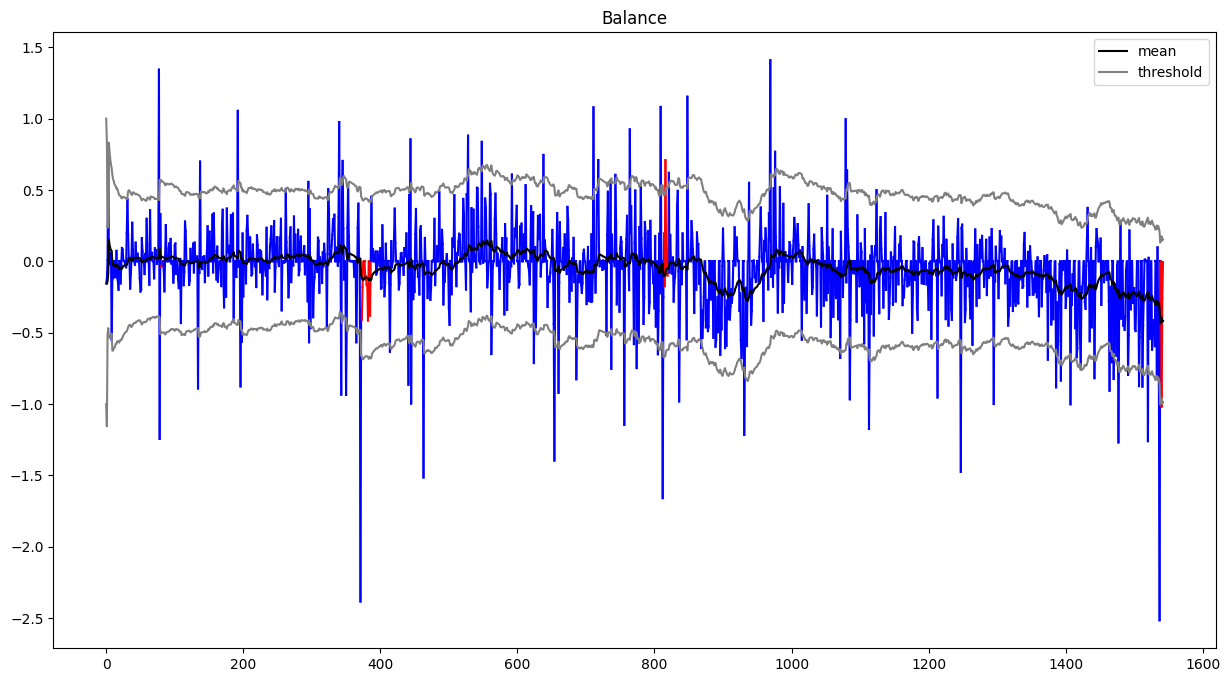

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1, len(data['Balance'].values)):
    
    x = [i-1, i]
    y = [data['Balance'].values[i-1], data['Balance'].values[i]]
    
    ax.plot(x, y, color=sr.breakpoints[i])
    
ax.plot([i for i in range(1, len(stat_trajectory))], mean_values[1:], color='black',label='mean')
ax.plot(np.array(mean_values) + np.sqrt(var_values), 'k', color='grey', label='threshold')
ax.plot(np.array(mean_values) - np.sqrt(var_values), 'k', color='grey')
plt.title('Balance')
plt.legend()
plt.show()